In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import nest_asyncio
import os
import datetime as dt
from sklearn.preprocessing import StandardScaler
nest_asyncio.apply()
plt.style.use('ggplot')

In [22]:
df = pd.read_csv('data/current.csv', skiprows=[1])
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
2,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
3,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
4,5/1/1959,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5476,24.3911,23.1161,32.5567,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,8/1/2024,20007.209,16322.1,121.052,1.530317e+06,710038.00000,103.0135,100.9825,100.9803,102.2118,...,119.653,128.291,31.26,35.81,27.97,67.9,551667.22,933066.90,5327.6461,19.6750
788,9/1/2024,20044.142,16333.7,121.690,1.541305e+06,716388.00000,102.5969,100.3826,100.0630,101.9696,...,119.220,128.682,31.44,36.00,28.11,70.1,553347.06,934283.59,5368.5818,17.6597
789,10/1/2024,20128.752,16397.9,121.948,1.539382e+06,720393.00000,102.0854,99.5434,98.9267,101.3127,...,119.064,129.169,31.55,36.22,28.14,70.5,554377.25,937299.96,5407.3304,19.9478
790,11/1/2024,20161.687,16432.8,122.519,1.544190e+06,725925.00000,102.2549,99.8216,99.4970,101.7893,...,119.112,129.375,31.61,36.21,28.29,71.8,555000.61,938899.31,5382.4019,15.9822


In [ ]:
economic_indicators = { # source: [3] in README.md
    "RPI": 5,
    "INDPRO": 5,  
    "CMRMTSPLx": 5,
    "HWI": 2,
    "HWIURATIO": 2,
    "CLF16OV": 5,
    "UNRATE": 2,
    "PAYEMS": 5,
    "CES0600000007": 5,
    "CPIAUCSL": 6,
    "FEDFUNDS": 2,
    "TB3MS": 2,
    "TB6MS": 2,
    "GS1": 2,
    "GS5": 2,
    "GS10": 2,
    "AAA": 2,
    "BAA": 2,
    "M1SL": 5,
    "M2SL": 5,
    "BUSLOANS": 5,
    "NONREVSL": 5,
    "INVEST": 5,
    "S&P 500": 5,
    "S&P div yield": 5,
    "S&P PE ratio": 5,
    "EXSZUSx": 5,
    "EXJPUSx": 5,
    "EXUSUKx": 5,
    "EXCAUSx": 5,
    "UEMPMEAN": 5,
    "AWHMAN": 1,
    "ISRATIOx": 5,
    "REALLN": 5,
    "PPICMM": 6,
    "PCEPI": 6,

}

transformation_codes = {
    1 : 'ident',
    2 : 'diff',
    5 : 'logdiff',
    6 : 'logdiffdiff'
}

In [24]:
df['date'] = pd.to_datetime(df['sasdate'])
df = df[['date'] + list(economic_indicators.keys())]
df

,date,RPI,INDPRO,CMRMTSPLx,HWI,HWIURATIO,CLF16OV,UNRATE,PAYEMS,CES0600000007,...,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,UEMPMEAN,AWHMAN,ISRATIOx,REALLN,PPICMM,PCEPI
0,1959-01-01,2583.560,21.9616,2.766768e+05,1357.0,0.333579,67936,6.0,52478,39.8,...,4.3122,359.8417,2.8065,0.9671,16.3,40.2,1.560000,24.9242,32.500,15.164
1,1959-02-01,2593.596,22.3917,2.787140e+05,1421.0,0.358386,67649,5.9,52688,39.7,...,4.3133,359.8417,2.8093,0.9748,15.5,40.3,1.539338,25.2270,32.500,15.179
2,1959-03-01,2610.396,22.7142,2.777753e+05,1524.0,0.400947,68068,5.6,53014,40.0,...,4.3228,359.8417,2.8127,0.9698,15.3,40.4,1.529007,25.4218,32.900,15.189
3,1959-04-01,2627.446,23.1981,2.833627e+05,1589.0,0.444973,68339,5.2,53321,40.2,...,4.3226,359.8417,2.8165,0.9636,14.9,40.5,1.529007,25.7261,32.700,15.219
4,1959-05-01,2642.720,23.5476,2.853072e+05,1655.0,0.475711,68178,5.1,53550,40.3,...,4.3228,359.8417,2.8145,0.9630,14.7,40.7,1.518675,26.0187,32.900,15.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,2024-08-01,20007.209,103.0135,1.530317e+06,7861.0,1.111724,168496,4.2,158770,40.6,...,0.8579,146.2641,1.2945,1.3655,21.0,40.7,1.380000,5607.5822,269.226,123.727
788,2024-09-01,20044.142,102.5969,1.541305e+06,7372.0,1.068251,168703,4.1,159025,40.7,...,0.8472,142.9540,1.3219,1.3546,22.6,40.7,1.370000,5607.0013,281.020,123.939
789,2024-10-01,20128.752,102.0854,1.539382e+06,7839.0,1.124355,168428,4.1,159068,40.6,...,0.8613,149.8909,1.3043,1.3757,22.9,40.6,1.370000,5614.2374,288.624,124.235
790,2024-11-01,20161.687,102.2549,1.544190e+06,8098.0,1.137200,168304,4.2,159280,40.6,...,0.8809,153.7126,1.2738,1.3973,23.6,40.8,1.370000,5618.6705,280.692,124.387


Make sure to first trim data down to no nulls

In [ ]:
# data processing
transformation_codes = {
    1 : 'ident',
    2 : 'diff',
    5 : 'logdiff',
    6 : 'logdiffdiff'
}


scaler = StandardScaler()

def process_column(col):
    c = col.fillna(method = 'ffill')
    scaler.fit(c.values.reshape(-1,1))
    return scaler.transform(c.values.reshape(-1,1))

feature_names = []

for c in economic_indicators.keys():
    
    code = transformation_codes[economic_indicators[c]]

    if code == 'ident':
        feature_names.append(c.replace(" ", "").lower())
        df[c.replace(" ", "").lower()] = process_column(df[c])
        
    elif code == 'diff':
        df[c.replace(" ", "").lower() + '_diff'] = df[c].diff()
        feature_names.append(c.replace(" ", "").lower() + '_diff')
        df[c.replace(" ", "").lower() + '_diff'] = process_column(df[c.replace(" ", "").lower() + '_diff'])
        
    elif code == 'logdiff':
        df[c.replace(" ", "").lower() + '_logdiff'] = np.log(df[c])
        df[c.replace(" ", "").lower() + '_logdiff'] = df[c.replace(" ", "").lower() + '_logdiff'].diff()
        df[c.replace(" ", "").lower() + '_logdiff'] = process_column(df[c.replace(" ", "").lower() + '_logdiff'])
        
        feature_names.append(c.replace(" ", "").lower() + '_logdiff')
        
    elif code == 'logdiffdiff':
        df[c.replace(" ", "").lower() + '_logdiffdiff'] = np.log(df[c])
        df[c.replace(" ", "").lower() + '_logdiffdiff'] = df[c.replace(" ", "").lower() + '_logdiffdiff'].diff()
        df[c.replace(" ", "").lower() + '_logdiffdiff'] = df[c.replace(" ", "").lower() + '_logdiffdiff'].diff()
        df[c.replace(" ", "").lower() + '_logdiffdiff'] = process_column(df[c.replace(" ", "").lower() + '_logdiffdiff'])
        feature_names.append(c.replace(" ", "").lower() + '_logdiffdiff')
        
df[feature_names]

/tmp/ipykernel_764/5881084.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c.replace(" ", "").lower() + '_logdiff'] = np.log(df[c])
/tmp/ipykernel_764/5881084.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c.replace(" ", "").lower() + '_logdiff'] = df[c.replace(" ", "").lower() + '_logdiff'].diff()
/tmp/ipykernel_764/5881084.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,rpi_logdiff,indpro_logdiff,cmrmtsplx_logdiff,hwi_diff,hwiuratio_diff,clf16ov_logdiff,unrate_diff,payems_logdiff,ces0600000007_logdiff,cpiaucsl_logdiffdiff,...,exszusx_logdiff,exjpusx_logdiff,exusukx_logdiff,excausx_logdiff,uempmean_logdiff,awhman,isratiox_logdiff,realln_logdiff,ppicmm_logdiffdiff,pcepi_logdiffdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.796321,NaN,NaN,NaN,NaN
1,0.108972,1.753217,0.416117,0.271405,0.495429,-1.737562,-0.227120,0.442311,-0.355737,NaN,...,0.092501,0.045645,0.094369,0.557622,-0.963326,-0.658466,-0.951324,0.894839,NaN,NaN
2,0.328900,1.240991,-0.447824,0.463330,0.865410,1.622522,-0.692539,0.813965,1.052201,-0.256576,...,0.172546,0.045645,0.104364,-0.422095,-0.255260,-0.520611,-0.474591,0.144154,0.370500,-0.173825
3,0.333481,1.922642,1.430881,0.276326,0.895939,0.911896,-0.925249,0.746614,0.696049,0.507041,...,0.080101,0.045645,0.110980,-0.517358,-0.511354,-0.382756,0.011861,0.864584,-0.556433,0.687051
4,0.272614,1.306702,0.376012,0.281247,0.619030,-1.132307,-0.227120,0.492190,0.345176,0.633543,...,0.083909,0.045645,0.013997,-0.083384,-0.265245,-0.107046,-0.477889,0.763629,0.369366,-0.758775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,-0.140606,0.286909,-0.145458,0.694625,0.503802,-0.023873,0.005590,-0.156253,0.342600,0.116908,...,-1.508264,-3.103318,0.320931,-0.359818,0.355725,-0.107046,0.537229,-1.179923,-0.478737,-0.230889
788,-0.064336,-0.604068,0.401481,-2.450003,-0.927428,0.025513,-0.227120,0.034036,0.341749,-0.029065,...,-0.434505,-0.926778,1.033320,-0.637331,1.383486,-0.107046,-0.513507,-1.190928,2.054383,0.251631
789,0.137555,-0.699142,-0.276377,2.254636,1.147614,-0.897521,0.005590,-0.194029,-0.347929,0.234241,...,0.761291,2.058578,-0.583462,1.121646,0.241101,-0.244901,0.011861,-0.952315,-0.491091,0.351461
790,-0.082190,-0.029875,0.075894,1.231033,0.246169,-0.608611,0.238299,-0.012610,-0.003090,0.251164,...,1.008013,1.115175,-1.066312,1.130836,0.562021,0.030809,0.011861,-1.038013,-1.655419,-0.609619


In [26]:

df = df[df.date > dt.datetime(year = 2001, month = 1, day = 1)]
print(len(df))

287


In [28]:
P = 5
lam = 0.3
lookforward = 12

In [ ]:


STAN_CODE = 'BVAR_minnesota_prior_stochastic_volatility.stan'

feature_names = feature_names[:20]

posterior = CmdStanModel(
    stan_file = STAN_CODE,
    cpp_options = { 
        'STAN_THREADS' : True, 
    }, 
    force_compile = True
)


data = {
    'T' : len(df),
    'P' : P,
    'D' : len(feature_names),
    'lambda' : lam,
    'lookforward' : lookforward,
    'y' : df[feature_names].values,
}

fit = posterior.sample(
    data = data, 
    seed = 1,
    chains = 4,
    adapt_delta = 0.81,
    max_treedepth = 9,
    output_dir  = 'tmp',
    inits = {},
    threads_per_chain = 4
)

# diagnostic tools
diagnostics = fit.diagnose()

print(diagnostics)

Clearing cmdstan dir...
Removed 5 files


14:38:26 - cmdstanpy - INFO - compiling stan file /home/nsand/documents/projects/recession/BVAR_minnesota_prior_stochastic_volatility.stan to exe file /home/nsand/documents/projects/recession/BVAR_minnesota_prior_stochastic_volatility
14:38:59 - cmdstanpy - INFO - compiled model executable: /home/nsand/documents/projects/recession/BVAR_minnesota_prior_stochastic_volatility
14:38:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:16:52 - cmdstanpy - INFO - CmdStan done processing.
17:16:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Random variable is -0.594033, but must be in the interval [0, 1] (in 'BVAR_minnesota_prior_stochastic_volatility.stan', line 46, column 4 to column 26)
	Exception: beta_lpdf: Random variable is -0.72469, but must be in the interval [0, 1] (in 'BVAR_minnesota_prior_stochastic_volatility.stan', line 46, column 4 to column 26)
	Exception: beta_lpdf: Random variable is -0.219356, but must be in the interval [0, 1] (in 'BVAR_minnesota_prior_stochastic_volatility.stan', line 46, column 4 to column 26)
	Exception: beta_lpdf: Random variable is -0.659135, but must be in the interval [0, 1] (in 'BVAR_minnesota_prior_stochastic_volatility.stan', line 46, column 4 to column 26)
	Exception: beta_lpdf: Random variable is -0.662528, but must be in the interval [0, 1] (in 'BVAR_minnesota_prior_stochastic_volatility.stan', line 46, column 4 to column 26)
	Excep

17:16:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 726 divergent transitions (72.6%)
	Chain 1 had 274 iterations at max treedepth (27.4%)
	Chain 2 had 1000 iterations at max treedepth (100.0%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Checking sampler transitions treedepth.
1274 of 1000 (127.40%) transitions hit the maximum treedepth limit of 9, or 2^9 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
742 of 1000 (74.20%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  y_ha

In [30]:

dims = {
    
    # parameters
    'A' : ['P', 'feature', 'feature2'],
    'h' : ['T'],
    'Omega' : ['feature', 'feature2'],
    'volatility' : ['T'],
    'phi_raw' : [],
    'phi' : [],
    'sigma_h' : [],
    
    # Data
    'y' : ['T', 'feature'],
    
    # PPC
    'y_hat' : ['T', 'feature'],
    
    # OOS Preds
    'y_forecast' : ['lookforward', 'feature'],
    'h_forecast' : ['lookforward']
    
}


coords = {
    'T' : df.date.dt.date.astype(str).values,
    'feature' : feature_names,
    'feature2' : feature_names,
    'P' : np.arange(1, P+1),
    'lookforward' : np.arange(1, lookforward+1)
}

observed_data = ['y']
ppcs = [
    'y_hat', 
    'volatility' # debateable if h is a PPC because it is a latent variable but it fits in spirit
    ]
predictions = [
    'y_forecast',
    'h_forecast'
    ]


idata = az.from_cmdstanpy(
        posterior = fit, 
        constant_data = {'y' : df[feature_names].values},              
        posterior_predictive = ppcs,                                               
        #predictions_constant_data = {cons : data[cons] for cons in pred_constant_data},
        predictions = predictions, 
        dims = dims, 
        coords = coords
    )

#az.to_netcdf(idata, 'VAR_trace.nc')

In [37]:
idata = az.from_netcdf('VAR_trace.nc')

In [38]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> constant_data

In [39]:
az.summary(idata.sel(chain = [0,1,2,3])).to_csv('summary.csv')

KeyboardInterrupt: 

/home/nsand/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


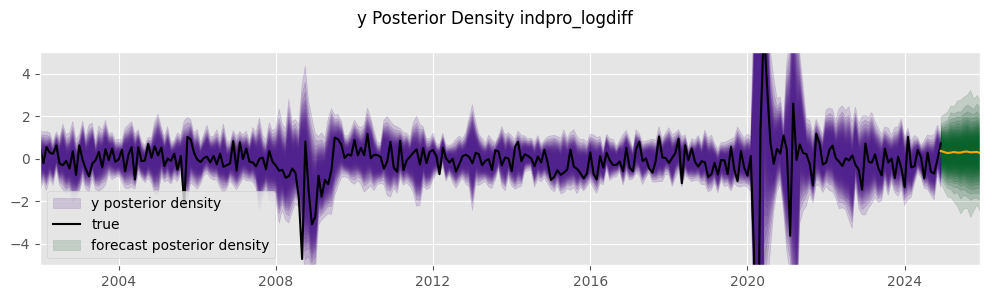

In [40]:
fig, ax = plt.subplots(1,1, sharey = True, figsize = [10,3])
quantiles = np.linspace(0.5, 0.99, 50)

chains = [1,2,3]
plot_realizations = False

colors = (quantiles - np.min(quantiles)) / (np.max(quantiles) - np.min(quantiles))
cmap1 = plt.get_cmap("Purples")
cmap2 = plt.get_cmap("Greens")

feat = feature_names[1]
x = pd.to_datetime(idata.posterior_predictive.T.to_dataframe()['T'])

for n, quant in enumerate(quantiles):

    ax.fill_between(x, idata.posterior_predictive['y_hat'].sel(feature = feat, chain = chains).quantile(1-quant, dim = ('chain', 'draw')), 
                    idata.posterior_predictive['y_hat'].sel(feature = feat, chain = chains).quantile(quant, dim = ('chain', 'draw')),
                    color = cmap1(colors[n]), alpha = 0.15, label ='y posterior density' if n == len(quantiles) - 1 else None)

chain_colours = {
    0 : 'green',
    1 : 'red',
    2 : 'orange',
    3 : 'magenta'
}
if plot_realizations:
    for i in range(5):
        ii = np.random.randint(0, 1000)
        chain = np.random.randint(1,3)
        ax.plot(x, idata.posterior_predictive['y_hat'].sel(feature = feat, chain = chain, draw = ii).values, 
                color = chain_colours[chain], linewidth = 0.4, label = 'realizations' if i == 0 else None)


plt.plot(x, df[feat], color = 'black', label = 'true')

# forecasting future
day_0 = pd.to_datetime(x[-1].value)
df_temp = pd.DataFrame()
df_temp['months to add'] = np.arange(1,lookforward + 1)
df_temp['dates'] = df_temp.apply(lambda x: day_0 + pd.DateOffset(months = x['months to add'] ), axis=1)
df_temp.loc[0,'dates'] = pd.to_datetime(x[-1].value)
df_temp = df_temp.drop('months to add', axis=1)
x_oos = df_temp['dates']

for n, quant in enumerate(quantiles):

    ax.fill_between(x_oos, idata.predictions['y_forecast'].sel(feature = feat, chain = chains).quantile(1-quant, dim = ('chain', 'draw')), 
                    idata.predictions['y_forecast'].sel(feature = feat, chain = chains).quantile(quant, dim = ('chain', 'draw')),
                    color = cmap2(colors[n]), alpha = 0.15, label ='forecast posterior density' if n == len(quantiles) - 1 else None)

ax.plot(x_oos, idata.predictions['y_forecast'].sel(feature = feat, chain = chains).median(dim = ('chain', 'draw')), color = 'orange')



plt.xlim(dt.datetime(year = 2002, month = 1, day = 1), dt.datetime(year = 2025, month = 12, day = 1))
plt.ylim(-5,5)
plt.suptitle(f'y Posterior Density {feat}')
plt.tight_layout()
plt.legend(loc = 'lower left')
plt.show()




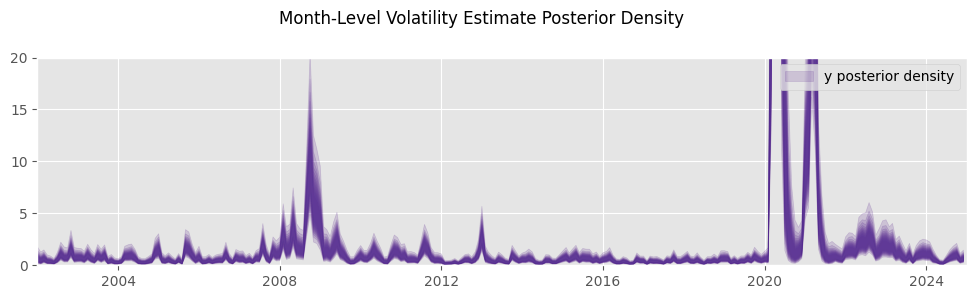

In [41]:
fig, ax = plt.subplots(1,1, sharey = True, figsize = [10,3])
quantiles = np.linspace(0.5, 0.99, 30)

colors = (quantiles - np.min(quantiles)) / (np.max(quantiles) - np.min(quantiles))
cmap1 = plt.get_cmap("Purples")
cmap2 = plt.get_cmap("Greens")

x = pd.to_datetime(idata.posterior_predictive.T.to_dataframe()['T'])

for n, quant in enumerate(quantiles):

    ax.fill_between(x, idata.posterior_predictive['volatility'].sel(chain = chains).quantile(1-quant, dim = ('chain', 'draw')), 
                    idata.posterior_predictive['volatility'].sel(chain = chains).quantile(quant, dim = ('chain', 'draw')),
                    color = cmap1(colors[n]), alpha = 0.15, label ='y posterior density' if n == len(quantiles) - 1 else None)

chain_colours = {
    0 : 'green',
    1 : 'red',
    2 : 'orange',
    3 : 'magenta'
}
if plot_realizations:
    for i in range(5):
        ii = np.random.randint(0, 1000)
        chain = np.random.randint(1,4)
        ax.plot(x, idata.posterior_predictive['volatility'].sel(chain = chain, draw = ii).values, 
                color = chain_colours[chain], linewidth = 0.4, label = 'realizations' if i == 0 else None)


plt.xlim(dt.datetime(year = 2002, month = 1, day = 1), dt.datetime(year = 2025, month = 1, day = 1))
plt.ylim(0,20)
plt.suptitle('Month-Level Volatility Estimate Posterior Density')
plt.tight_layout()
plt.legend()
plt.show()


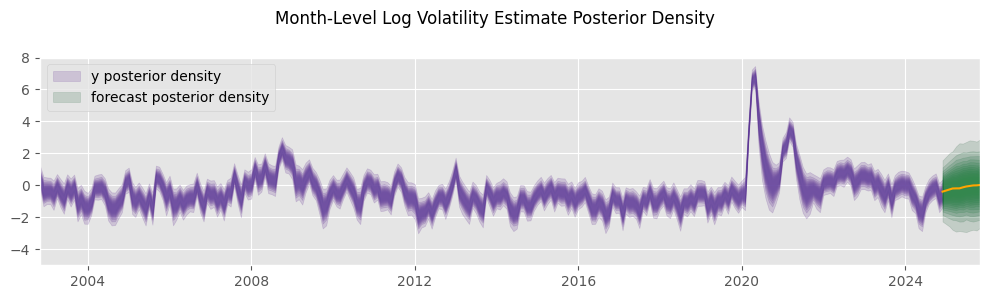

In [42]:
fig, ax = plt.subplots(1,1, sharey = True, figsize = [10,3])
quantiles = np.linspace(0.5, 0.99, 20)

colors = (quantiles - np.min(quantiles)) / (np.max(quantiles) - np.min(quantiles))
cmap1 = plt.get_cmap("Purples")
cmap2 = plt.get_cmap("Greens")

x = pd.to_datetime(idata.posterior_predictive.T.to_dataframe()['T'])

for n, quant in enumerate(quantiles):

    ax.fill_between(x, idata.posterior['h'].sel(chain = chains).quantile(1-quant, dim = ('chain', 'draw')), 
                    idata.posterior['h'].sel(chain = chains).quantile(quant, dim = ('chain', 'draw')),
                    color = cmap1(colors[n]), alpha = 0.15, label ='y posterior density' if n == len(quantiles) - 1 else None)

chain_colours = {
    0 : 'green',
    1 : 'red',
    2 : 'orange',
    3 : 'magenta'
}

if plot_realizations:
    for i in range(10):
        chain = np.random.randint(1,4)
        ii = np.random.randint(0, 1000)
        
        ax.plot(x, idata.posterior['h'].sel(chain = chain, draw = ii).values, 
                color = chain_colours[chain], linewidth = 0.4, label = 'realizations' if i == 0 else None)


# forecasting future
day_0 = pd.to_datetime(x[-1].value)
df_temp = pd.DataFrame()
df_temp['months to add'] = np.arange(1,lookforward+1)
df_temp['dates'] = df_temp.apply(lambda x: day_0 + pd.DateOffset(months = x['months to add'] ), axis=1)
df_temp.loc[0,'dates'] = pd.to_datetime(x[-1].value)
df_temp = df_temp.drop('months to add', axis=1)
x_oos = df_temp['dates']

for n, quant in enumerate(quantiles):

    ax.fill_between(x_oos, idata.predictions['h_forecast'].sel(chain = chains).quantile(1-quant, dim = ('chain', 'draw')), 
                    idata.predictions['h_forecast'].sel(chain = chains).quantile(quant, dim = ('chain', 'draw')),
                    color = cmap2(colors[n]), alpha = 0.15, label ='forecast posterior density' if n == len(quantiles) - 1 else None)

ax.plot(x_oos, idata.predictions['h_forecast'].sel(chain = chains).median(dim = ('chain', 'draw')), color = 'orange')



plt.xlim(dt.datetime(year = 2002, month = 11, day = 1), dt.datetime(year = 2025, month = 11, day = 1))
plt.ylim(-5,8)
plt.suptitle('Month-Level Log Volatility Estimate Posterior Density')
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.show()

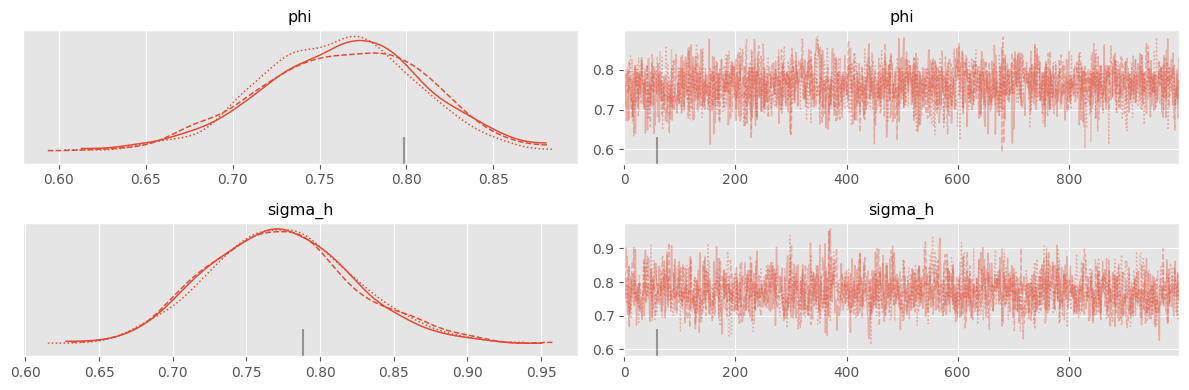

In [ ]:
az.plot_trace(idata.sel(chain = chains), var_names = ['phi', 'sigma_h'])
plt.tight_layout()
plt.show()

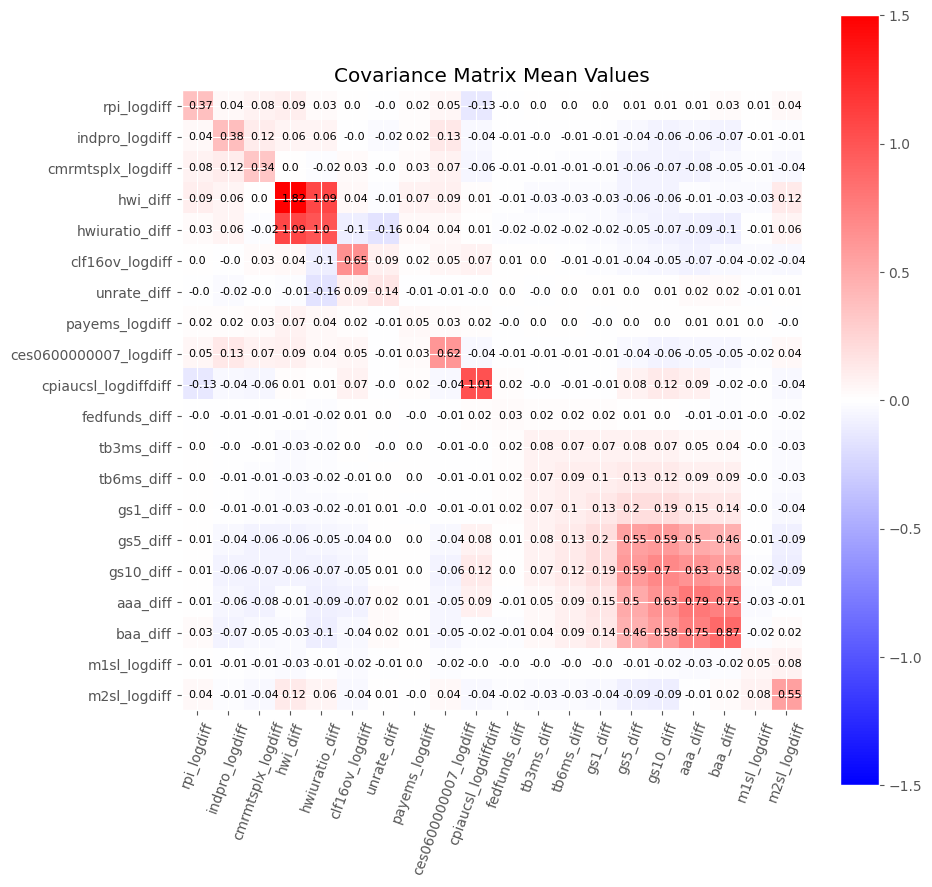

In [43]:
omega = idata.posterior.Omega.sel(chain = chains).mean(dim = ('chain', 'draw'))

plt.figure(figsize = [10,10])
plt.title('Covariance Matrix Mean Values')
plt.imshow(omega.values, cmap = 'bwr')
plt.clim(-1.5,1.5)
plt.colorbar()
plt.xticks(np.arange(len(feature_names)), feature_names, rotation = 70)
plt.yticks(np.arange(len(feature_names)), feature_names)
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        plt.text(i-0.27,j+0.1, round(omega.values[i,j], 2), fontsize = 8)
plt.show()

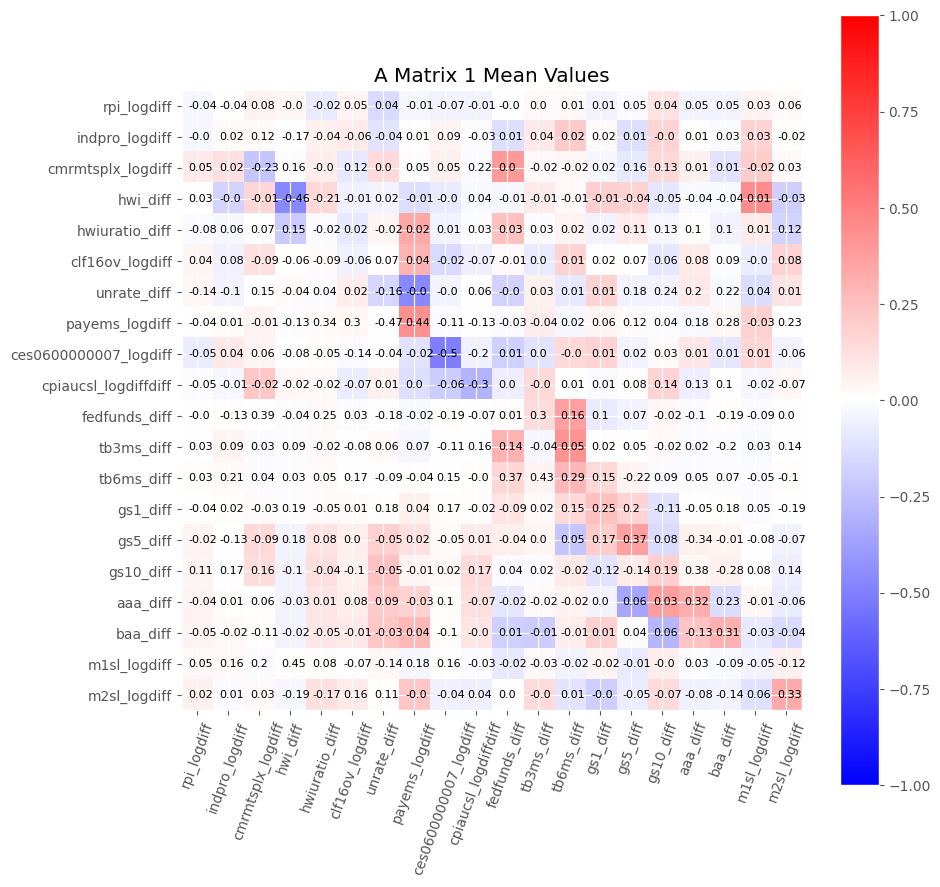

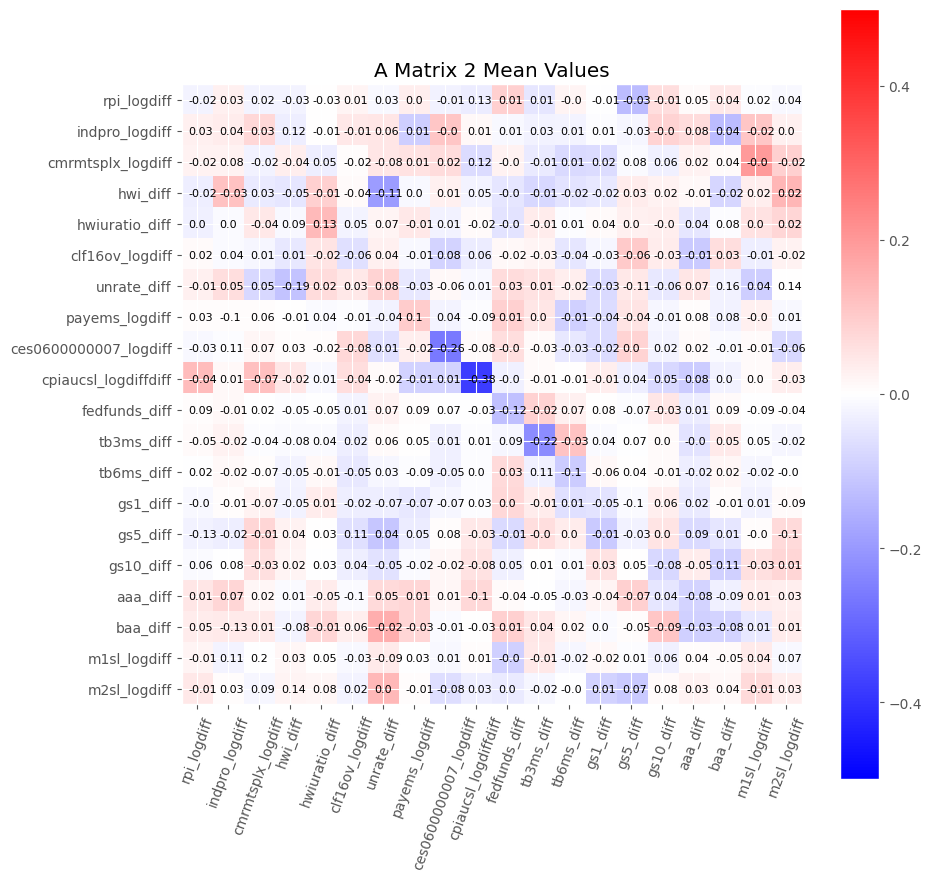

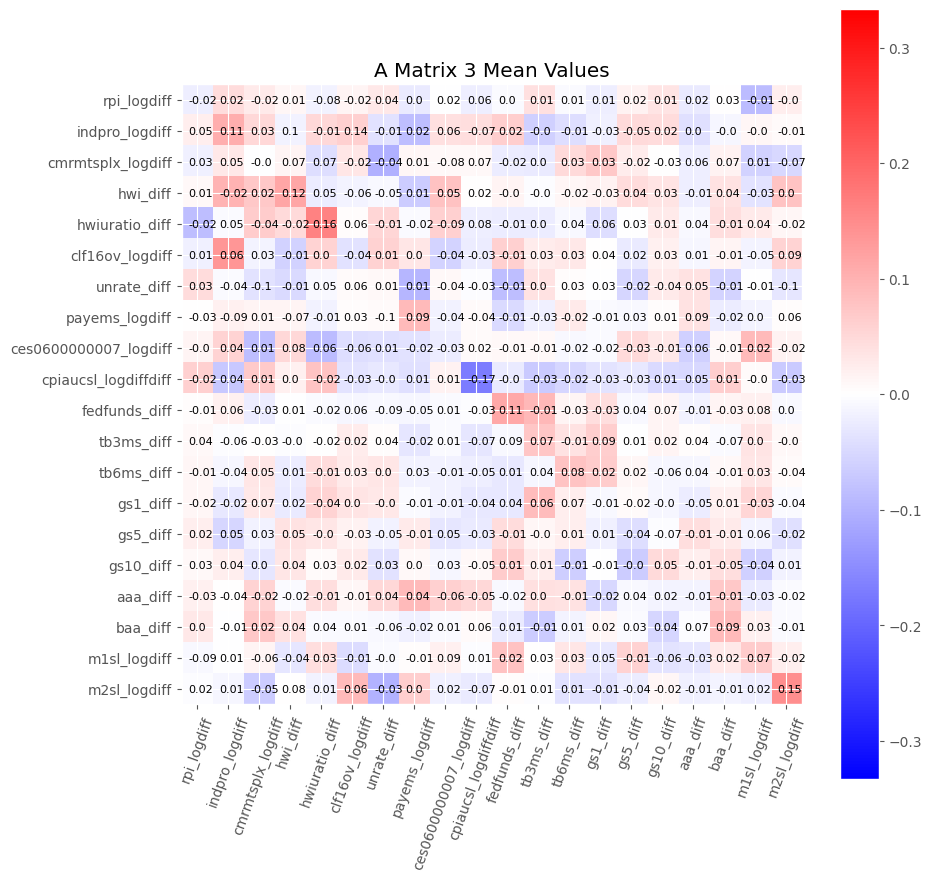

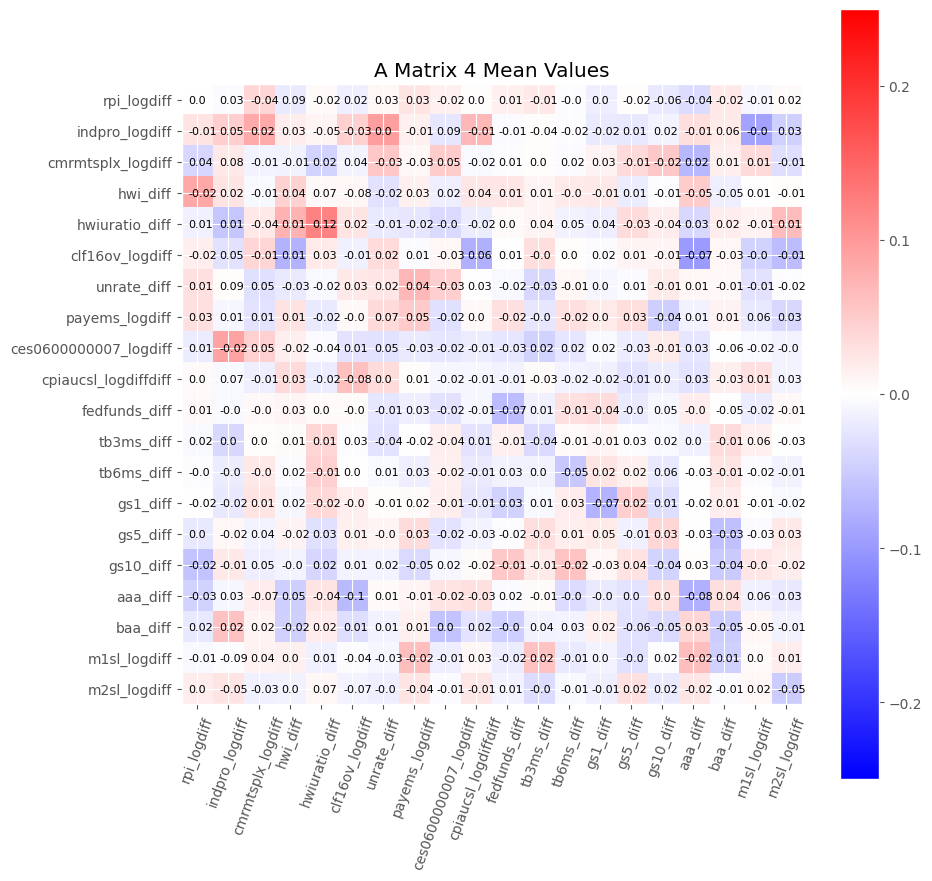

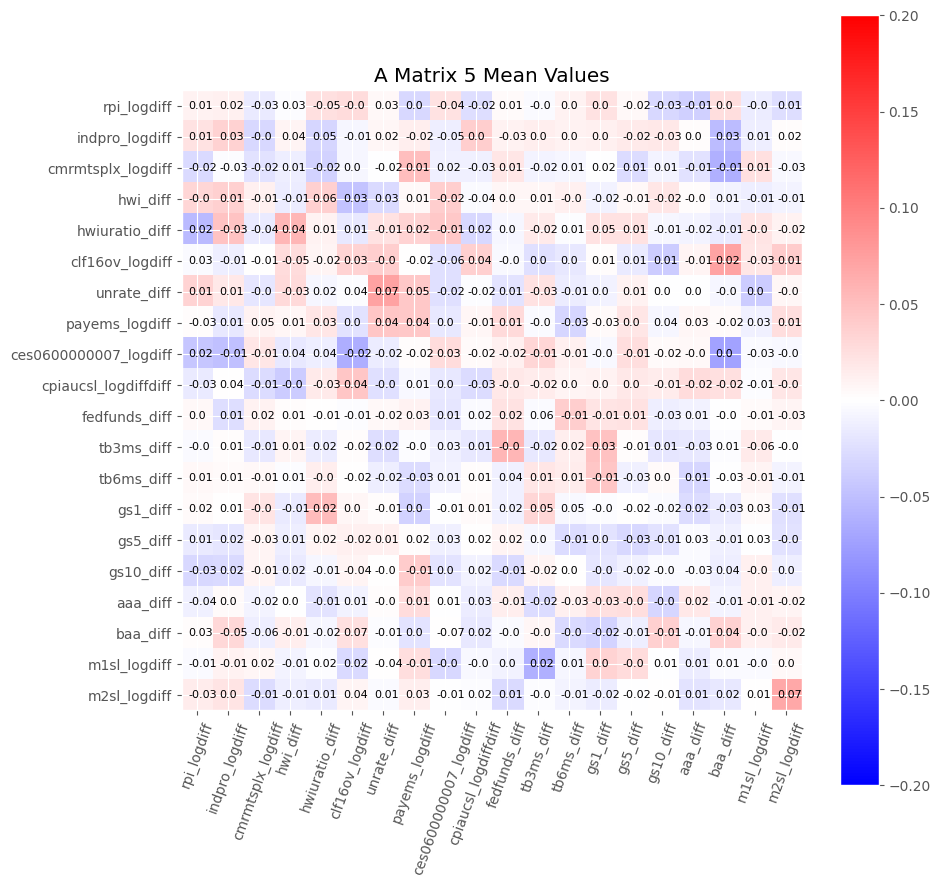

In [44]:
for p in range(1, P+1):
    A = idata.posterior.A.sel(P = p, chain = chains).mean(dim = ('chain', 'draw'))

    plt.figure(figsize = [10,10])
    plt.title(f'A Matrix {p} Mean Values')
    plt.imshow(A.values, cmap = 'bwr')
    plt.clim(-1/p,1/p)
    plt.colorbar()
    plt.xticks(np.arange(len(feature_names)), feature_names, rotation = 70)
    plt.yticks(np.arange(len(feature_names)), feature_names)
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            plt.text(i-0.27,j+0.1, round(A.values[i,j], 2), fontsize = 8)
    #plt.tight_layout()
    plt.show()

## Measuring "predicatability" of indices

In [45]:
total_autoregressive_contrib = np.abs(idata.posterior.A.sel(chain = [1,2,3]).sum(dim = ('P', 'feature2'))).mean(dim = ('chain', 'draw'))

total_autoregressive_contrib.to_dataframe()

,A
feature,
rpi_logdiff,0.383364
indpro_logdiff,1.336342
cmrmtsplx_logdiff,0.866225
hwi_diff,0.674786
hwiuratio_diff,0.985340
clf16ov_logdiff,0.523495
unrate_diff,0.688384
payems_logdiff,1.069034
ces0600000007_logdiff,1.068454
